In [1]:
import os
import pickle
import numpy as np
import tkinter as tk
from tkinter import filedialog
from img2vec_pytorch import Img2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

## Grain image classification

This notebook loads a dataset of images of four kinds of different grains represented in .png format, trains machine learning models for classification, and tests the models.

Choose the dataset:

In [2]:
# dataset = "data/quantity"
dataset = "data/quality"

Functions for loading and processing the images:

In [3]:
from PIL import Image

img2vec = Img2Vec()

def load_image(file, i):
    if not file.lower().endswith(".png"):
        raise Exception("Invalid file name")
    print(f"Loading {file}")
    image = Image.open(file)
    features = img2vec.get_vec(image)
    label = i
    return features, label

def prepare_data(directory, data_file, labels_file):
    failed_files = []
    data = []
    labels = []

    # load the images and labels from the directory
    for i in range(4):
        path = os.path.join(directory, ["kaura", "ohra", "ruis", "vehna"][i])
        files = [os.path.join(path, file) for file in os.listdir(path)]
        for j, file in enumerate(files):
            try:
                img, label = load_image(file, i)
                data.append(img)
                labels.append(label)
                print(f"Loaded {file}")
            except:
                failed_files.append(file)
                continue

    if not failed_files:
        print("All files loaded successfully")
    else:
        print(f"Failed to load files {failed_files}")

    # save the data and labels as numpy arrays for classification
    data_np = np.array(data)
    labels_np = np.array(labels)
    print("Saving data...")
    np.save(data_file, data_np)
    np.save(labels_file, labels_np)
    print(f"Data saved successfully in {data_file} and {labels_file}")
    return data_np, labels_np

def load_cached(directory, data_file, labels_file):
    try:
        data, labels = np.load(data_file), np.load(labels_file)
        print('Successfully loaded cached data')
        return data, labels
    except:
        return prepare_data(directory, data_file, labels_file)

c:\Users\mirok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mirok\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load the training data:

In [4]:
def load_data():
    if dataset == "data/quality":
        x, y = load_cached(dataset + "/train", "training_data_quality.npy", "training_labels_quality.npy")
    else:
        x, y = load_cached(dataset + "/train", "training_data_quantity.npy", "training_labels_quantity.npy")
    return x, y

print("Loading data...")
x_train, y_train = load_data()
print("Data loaded successfully")

Loading data...
Successfully loaded cached data
Data loaded successfully


Train the basic models:

In [5]:
def train_models(x_train, y_train):

    print("Training random forest model...")
    random_forest_model = RandomForestClassifier()
    random_forest_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(random_forest_model, open("random_forest_model_quality.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_model_quality.sav")
    else:
        pickle.dump(random_forest_model, open("random_forest_model_quantity.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_model_quantity.sav")

    print("Training kNN model...")
    knn_model = KNeighborsClassifier()
    knn_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(knn_model, open("knn_model_quality.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_model_quality.sav")
    else:
        pickle.dump(knn_model, open("knn_model_quantity.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_model_quantity.sav")

    print("Training MLP model...")
    MLP_model = MLPClassifier()
    MLP_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(MLP_model, open("MLP_model_quality.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_quality.sav")
    else:
        pickle.dump(MLP_model, open("MLP_model_quantity.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_quantity.sav")

train_models(x_train, y_train)

Training random forest model...
Random forest model trained successfully and saved in random_forest_model_quality.sav
Training kNN model...
kNN model trained successfully and saved in knn_model_quality.sav
Training MLP model...
MLP model trained successfully and saved in MLP_model_quality.sav


Train the optimized models:

In [6]:
def train_models(x_train, y_train):

    print("Training random forest model...")
    param_grid = {
        "n_estimators": [200],
        "max_features": ["sqrt", None],
        "max_samples": [0.75, 1.0]
    }
    random_forest_model = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, refit=True)
    random_forest_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(random_forest_model.best_estimator_, open("random_forest_model_o_quality.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_model_o_quality.sav")
    else:
        pickle.dump(random_forest_model.best_estimator_, open("random_forest_model_o_quantity.sav", 'wb'))
        print("Random forest model trained successfully and saved in random_forest_o_model_quantity.sav")
    print("Best parameters: ", random_forest_model.best_params_)
    print("Best score: ", round(random_forest_model.best_score_, 3))

    print("Training kNN model...")
    param_grid = {
        "n_neighbors": [3, 5, 7, 9, 11, 13],
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"]
    }
    knn_model = GridSearchCV(KNeighborsClassifier(), param_grid, n_jobs=-1, refit=True)
    knn_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(knn_model.best_estimator_, open("knn_model_o_quality.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_model_o_quality.sav")
    else:
        pickle.dump(knn_model.best_estimator_, open("knn_model_o_quantity.sav", 'wb'))
        print("kNN model trained successfully and saved in knn_model_o_quantity.sav")
    print("Best parameters: ", knn_model.best_params_)
    print("Best score: ", round(knn_model.best_score_, 3))

    print("Training MLP model...")
    param_grid = {
        "hidden_layer_sizes": [(100,), (500,), (200, 200), (500, 50), (150, 100, 50), (500, 500, 500)],
        "activation": ["logistic", "relu"],
        "learning_rate": ["constant", "invscaling"],
        "alpha": [0.0001, 0.001]
    }
    MLP_model = GridSearchCV(MLPClassifier(), param_grid, n_jobs=-1, refit=True)
    MLP_model.fit(x_train, y_train)
    if dataset == "data/quality":
        pickle.dump(MLP_model.best_estimator_, open("MLP_model_o_quality.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_o_quality.sav")
    else:
        pickle.dump(MLP_model.best_estimator_, open("MLP_model_o_quantity.sav", 'wb'))
        print("MLP model trained successfully and saved in MLP_model_o_quantity.sav")
    print("Best parameters: ", MLP_model.best_params_)
    print("Best score: ", round(MLP_model.best_score_, 3))

train_models(x_train, y_train)

Training random forest model...
Random forest model trained successfully and saved in random_forest_model_o_quality.sav
Best parameters:  {'max_features': 'sqrt', 'max_samples': 1.0, 'n_estimators': 200}
Best score:  0.917
Training kNN model...
kNN model trained successfully and saved in knn_model_o_quality.sav
Best parameters:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best score:  0.921
Training MLP model...
MLP model trained successfully and saved in MLP_model_o_quality.sav
Best parameters:  {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (200, 200), 'learning_rate': 'constant'}
Best score:  0.951


Load the test data:

In [7]:
if dataset == "data/quality":
    x_test, y_test = load_cached(dataset + "/holdout", "holdout_data_quality.npy", "holdout_labels_quality.npy")
else:
    x_test, y_test = load_cached(dataset + "/holdout", "holdout_data_quantity.npy", "holdout_labels_quantity.npy")

Successfully loaded cached data


Evaluate the basic models on the test data:

RF accuracy:  0.914
KNN accuracy:  0.913
MLP accuracy:  0.956


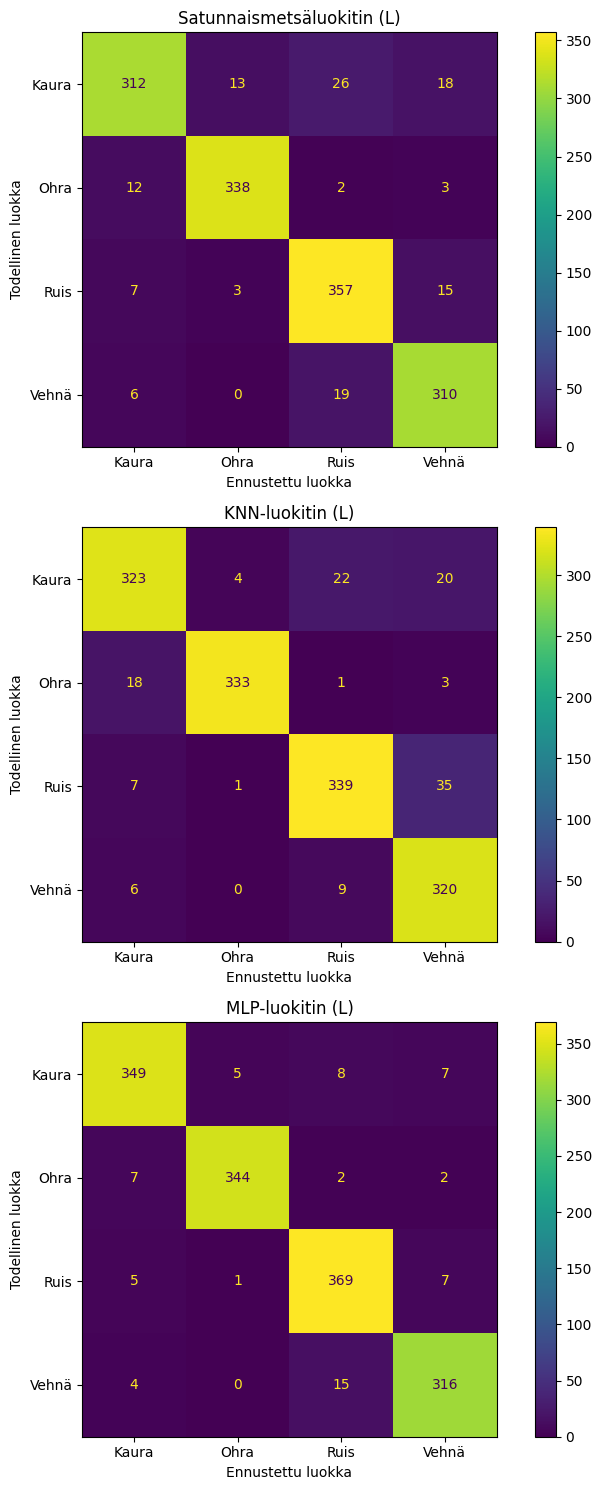

In [8]:
import matplotlib.pyplot as plt

def evaluate_models(x_test, y_test):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

    models = ["random_forest_model", "knn_model", "MLP_model"]
    titles = ["RF", "KNN", "MLP"]

    set = "L" if dataset == "data/quality" else "M"

    for i, model_name in enumerate(models):
        if dataset == "data/quality":
            model = pickle.load(open(f"{model_name}_quality.sav", 'rb'))
        else:
            model = pickle.load(open(f"{model_name}_quantity.sav", 'rb'))
        accuracy = model.score(x_test, y_test)
        print(f"{titles[i]} accuracy: ", round(accuracy, 3))

        y_pred = model.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kaura", "Ohra", "Ruis", "Vehnä"])
        disp.plot(ax=axs[i])
        if model_name == "random_forest_model":
            disp.im_.axes.set_title(f"Satunnaismetsäluokitin ({set})")
        else:
            axs[i].set_title(f"{titles[i]}-luokitin ({set})")
        axs[i].set_xlabel("Ennustettu luokka")
        axs[i].set_ylabel("Todellinen luokka")

    plt.tight_layout()
    plt.show()

evaluate_models(x_test, y_test)

Test the optimized models on the test data:

RF accuracy:  0.924
KNN accuracy:  0.923
MLP accuracy:  0.954


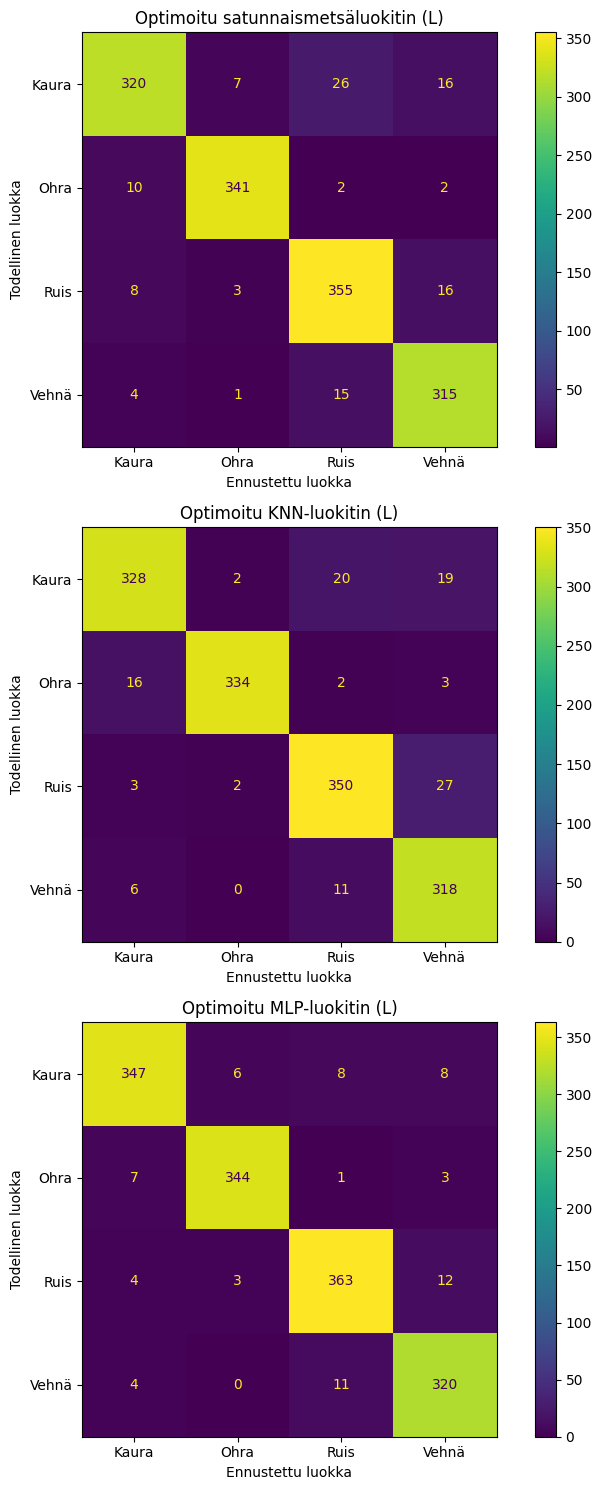

In [9]:
import matplotlib.pyplot as plt

def evaluate_models(x_test, y_test):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

    models = ["random_forest_model", "knn_model", "MLP_model"]
    titles = ["RF", "KNN", "MLP"]

    set = "L" if dataset == "data/quality" else "M"

    for i, model_name in enumerate(models):
        if dataset == "data/quality":
            model = pickle.load(open(f"{model_name}_o_quality.sav", 'rb'))
        else:
            model = pickle.load(open(f"{model_name}_o_quantity.sav", 'rb'))
        accuracy = model.score(x_test, y_test)
        print(f"{titles[i]} accuracy: ", round(accuracy, 3))

        y_pred = model.predict(x_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Kaura", "Ohra", "Ruis", "Vehnä"])
        disp.plot(ax=axs[i])
        if model_name == "random_forest_model":
            disp.im_.axes.set_title(f"Optimoitu satunnaismetsäluokitin ({set})")
        else:
            axs[i].set_title(f"Optimoitu {titles[i]}-luokitin ({set})")
        axs[i].set_xlabel("Ennustettu luokka")
        axs[i].set_ylabel("Todellinen luokka")

    plt.tight_layout()
    plt.show()

evaluate_models(x_test, y_test)

Test image files manually:

In [10]:
# model = pickle.load(open("MLP_model_quality.sav", 'rb'))
# while True:

#     try:
#         # open a file browser to select a file from your storage

#         root = tk.Tk()
#         root.withdraw()

#         file_path = filedialog.askopenfilename()

#         # read the image

#         img = load_image(file_path, 0)[0]

#         # predict the class

#         prediction = model.predict([img])

#         if prediction[0] == 0:
#             print("Prediction: kaura")
#         elif prediction[0] == 1:
#             print("Prediction: ohra")
#         elif prediction[0] == 2:
#             print("Prediction: ruis")
#         elif prediction[0] == 3:
#             print("Prediction: vehnä")

#     except:
#         print("File browser closed")
#         break
